In [1]:
!uv pip install -q --system numba-cuda==0.4.0
!pip install --upgrade numba

In [3]:
import numba.cuda as cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import numpy as np
import time

Image shape: (604, 900, 3)


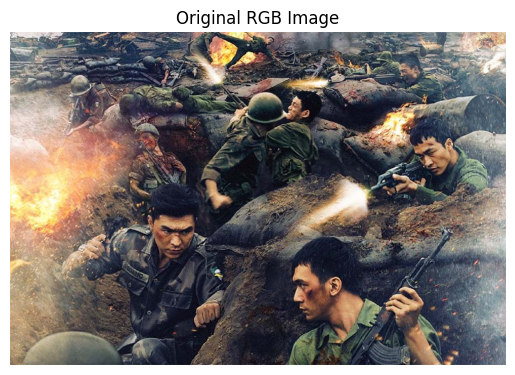

In [4]:
img_path = "/content/fl.jpg"

img = plt.imread(img_path)
if img.dtype != np.uint8:
    img = (img * 255).astype(np.uint8)
if img.shape[2] == 4:
    img = img[:, :, :3]
height, width, _ = img.shape
print(f"Image shape: {img.shape}")

plt.imshow(img)
plt.title("Original RGB Image")
plt.axis("off")
plt.show()

CPU time: 0.013977 s


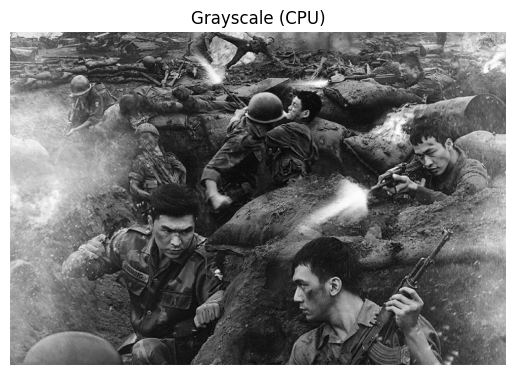

In [5]:
start_cpu = time.time()
gray_cpu = (img[:, :, 0] / 3 +
            img[:, :, 1] / 3 +
            img[:, :, 2] / 3)
end_cpu = time.time()
cpu_time = end_cpu - start_cpu

print(f"CPU time: {cpu_time:.6f} s")

plt.imshow(gray_cpu, cmap="gray")
plt.title("Grayscale (CPU)")
plt.axis("off")
plt.show()

In [6]:
@cuda.jit
def rgb_to_gray_2d(src, dst):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if x < dst.shape[0] and y < dst.shape[1]:
        r = src[x, y, 0]
        g = src[x, y, 1]
        b = src[x, y, 2]
        dst[x, y] = np.uint8((r + g + b) / 3)

GPU time: 0.8162431716918945


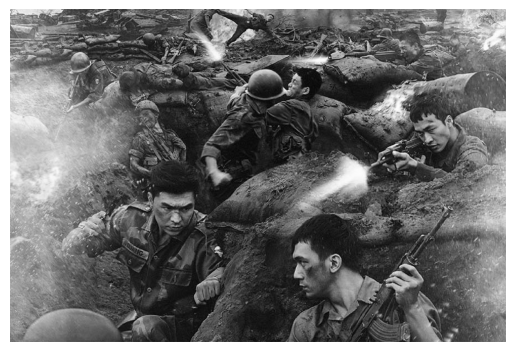

In [9]:
import math
src_gpu = cuda.to_device(img)

dst_gpu = cuda.device_array((height, width), dtype=np.uint8)

threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(height / threads_per_block[0])
blocks_per_grid_y = math.ceil(width  / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

start_gpu = time.time()
rgb_to_gray_2d[blocks_per_grid, threads_per_block](src_gpu, dst_gpu)
cuda.synchronize()
end_gpu = time.time()

print("GPU time:", end_gpu - start_gpu)

gray_gpu = dst_gpu.copy_to_host()
plt.imshow(gray_gpu, cmap='gray')
plt.axis('off')
plt.show()


In [14]:
block_sizes = [(8,8), (16,16), (32,8), (8,32), (32,16), (16,32), (32,32)]
gpu_times = []

for block in block_sizes:
    threads_per_block = block
    blocks_per_grid_x = math.ceil(height / threads_per_block[0])
    blocks_per_grid_y = math.ceil(width  / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    start_gpu = time.time()
    rgb_to_gray_2d[blocks_per_grid, threads_per_block](src_gpu, dst_gpu)
    cuda.synchronize()
    end_gpu = time.time()

    gpu_time = end_gpu - start_gpu
    gpu_times.append(gpu_time)
    print(f"Block {block}: GPU time = {gpu_time:.6f} s")

speedups = [cpu_time / t for t in gpu_times]


Block (8, 8): GPU time = 0.001075 s
Block (16, 16): GPU time = 0.000282 s
Block (32, 8): GPU time = 0.000282 s
Block (8, 32): GPU time = 0.000231 s
Block (32, 16): GPU time = 0.000216 s
Block (16, 32): GPU time = 0.000221 s
Block (32, 32): GPU time = 0.000295 s
